In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

Accessing

In [2]:
# pip install jdcal

import sqlite3
import pandas as pd
import jdcal
from datetime import datetime


state_to_id = {
    "AL": 1, "AZ": 2, "AR": 3, "CA": 4, "CO": 5,
    "CT": 6, "DE": 7, "FL": 8, "GA": 9, "ID": 10,
    "IL": 11, "IN": 12, "IA": 13, "KS": 14, "KY": 15,
    "LA": 16, "ME": 17, "MD": 18, "MA": 19, "MI": 20,
    "MN": 21, "MS": 22, "MO": 23, "MT": 24, "NE": 25,
    "NV": 26, "NH": 27, "NJ": 28, "NM": 29, "NY": 30,
    "NC": 31, "ND": 32, "OH": 33, "OK": 34, "OR": 35,
    "PA": 36, "RI": 37, "SC": 38, "SD": 39, "TN": 40,
    "TX": 41, "UT": 42, "VT": 43, "VA": 44, "WA": 45,
    "WV": 46, "WI": 47, "WY": 48, "HI": 49, "AK": 50
}


def julian_to_gregorian(julian_date):
    year, month, day, frac = jdcal.jd2gcal(jdcal.MJD_0, julian_date - jdcal.MJD_0)
    return datetime(year, month, day)


conn = sqlite3.connect("../Data/FPA_FOD_20170508.sqlite")
df = pd.read_sql_query("SELECT STATE, DISCOVERY_DATE FROM Fires", conn) #"SELECT * FROM 'Fires'",conn

df['DISCOVERY_DATE'] = df['DISCOVERY_DATE'].apply(julian_to_gregorian)

df['year'] = df['DISCOVERY_DATE'].dt.year
df['month'] = df['DISCOVERY_DATE'].dt.month

df = df.drop('DISCOVERY_DATE', axis=1)

df['STATE'] = df['STATE'].map(state_to_id)

df = df.dropna(subset=['STATE'])

df['STATE'] = df['STATE'].astype(int)

# Rename the STATE column to state
df.rename(columns={'STATE': 'state'}, inplace=True)

df.to_csv("../Data/data.csv", index=False)

Processiong

In [4]:
import pandas as pd

# Define state codes and month codes
state_codes = {
    "Alabama": 1, "Arizona": 2, "Arkansas": 3, "California": 4, "Colorado": 5,
    "Connecticut": 6, "Delaware": 7, "Florida": 8, "Georgia": 9, "Idaho": 10,
    "Illinois": 11, "Indiana": 12, "Iowa": 13, "Kansas": 14, "Kentucky": 15,
    "Louisiana": 16, "Maine": 17, "Maryland": 18, "Massachusetts": 19, "Michigan": 20,
    "Minnesota": 21, "Mississippi": 22, "Missouri": 23, "Montana": 24, "Nebraska": 25,
    "Nevada": 26, "New Hampshire": 27, "New Jersey": 28, "New Mexico": 29, "New York": 30,
    "North Carolina": 31, "North Dakota": 32, "Ohio": 33, "Oklahoma": 34, "Oregon": 35,
    "Pennsylvania": 36, "Rhode Island": 37, "South Carolina": 38, "South Dakota": 39,
    "Tennessee": 40, "Texas": 41, "Utah": 42, "Vermont": 43, "Virginia": 44,
    "Washington": 45, "West Virginia": 46, "Wisconsin": 47, "Wyoming": 48, "Alaska": 50
}

month_codes = {
    "January": 1, "February": 2, "March": 3, "April": 4, "May": 5, "June": 6, 
    "July": 7, "August": 8, "September": 9, "October": 10, "November": 11, "December": 12
}

# Function to categorize fire count
def categorize_fire_count(fire_count):
    if fire_count <= 3:
        return 1
    elif fire_count <= 29:
        return 2
    elif fire_count <= 141:
        return 3
    elif fire_count <= 348:
        return 4
    else:
        return 5

# Load the wildfire data
wilds = pd.read_csv('../Data/data.csv')

# Preprocess to create a summary of fire counts per state and year for each month
fire_summary = wilds.groupby(['state', 'year', 'month']).size().reset_index(name='count')
fire_summary_dict = {(row['state'], row['year'], row['month']): row['count'] for _, row in fire_summary.iterrows()}

# File paths of datasets to be processed
file_paths = [
    'climdiv-pcpnst-v1.0.0-20231106.txt', 'climdiv-pdsist-v1.0.0-20231106.txt',
    'climdiv-phdist-v1.0.0-20231106.txt', 'climdiv-sp01st-v1.0.0-20231106.txt',
    'climdiv-sp02st-v1.0.0-20231106.txt', 'climdiv-sp06st-v1.0.0-20231106.txt',
    'climdiv-sp12st-v1.0.0-20231106.txt', 'climdiv-sp24st-v1.0.0-20231106.txt',
    'climdiv-tmaxst-v1.0.0-20231106.txt', 'climdiv-tminst-v1.0.0-20231106.txt',
    'climdiv-tmpcst-v1.0.0-20231106.txt', 'climdiv-zndxst-v1.0.0-20231106.txt'
]

# Initialize DataFrame to store the combined data
combined_df = None

# Process each file and merge into combined_df
for file_path in file_paths:
    data = []
    with open('../Data/'+file_path, 'r') as file:
        for line in file:
            words = line.split()
            state_id = int(words[0][:3])
            year_val = int(words[0][-4:])
            monthly_data = [float(word) for word in words[1:13]]
            data.append([state_id, year_val] + monthly_data)

    name = file_path.split('/')[-1].split('-')[1]
    columns = ['state', 'year'] + [f'{name}_m{i}' for i in range(1, 13)]
    df = pd.DataFrame(data, columns=columns)

    if combined_df is None:
        combined_df = df
    else:
        combined_df = pd.merge(combined_df, df, on=['state', 'year'])

# Categorize fire counts for each month
for month in range(1, 13):
    combined_df[f'f{month}'] = combined_df.apply(
        lambda row: categorize_fire_count(
            fire_summary_dict.get((row['state'], row['year'], month), 0)
        ), axis=1
    )

# Split the dataset into training, reference, and testing datasets
training_df = combined_df[(combined_df['year'] >= 1992) & (combined_df['year'] <= 2013) & (combined_df['state'] < 49)]
reference = combined_df[(combined_df['year'] >= 2014) & (combined_df['year'] <= 2015) & (combined_df['state'] < 49)]
testing_df = reference.copy()

# Set fire counts to 0 in the testing dataset
for i in range(1, 13):
    testing_df[f'f{i}'] = 0

# Save the datasets
training_df.to_csv('../Data/training.csv', index=False)
reference.to_csv('../Data/reference.csv', index=False)
testing_df.to_csv('../Data/testing.csv', index=False)

print("Datasets saved successfully.")

Datasets saved successfully.


anomaly detection

In [18]:
import pandas as pd
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler

train_df = pd.read_csv('../Data/training.csv')
test_df = pd.read_csv('../Data/testing.csv')
reference_df = pd.read_csv('../Data/reference.csv')

X_train = train_df.drop(columns=[f'f{i}' for i in range(1, 13)])
X_test = test_df.drop(columns=[f'f{i}' for i in range(1, 13)])
y_reference = reference_df[[f'f{i}' for i in range(1, 13)]]

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

iso_forest = IsolationForest(n_estimators=100, contamination=0.5, random_state=42)
iso_forest.fit(X_train_scaled)

anomalies = iso_forest.predict(X_test_scaled)

test_df['anomaly'] = anomalies

anomalous_data = test_df[test_df['anomaly'] == -1]


print(f"Total data points in testing set: {len(test_df)}\n")
print(f"Number of anomalies detected: {len(anomalous_data)}\n")

print("\nAnomaly Detection Comparison with Reference Data:\n")
for i in range(1, 13):
    anomaly_count = anomalous_data[anomalous_data[f'f{i}'] == 1].shape[0]
    actual_fire_count = y_reference[y_reference[f'f{i}'] == 1].shape[0]
    print(f"Month {i} - Detected Anomalies: {anomaly_count}, Actual Fires: {actual_fire_count}\n")


Total data points in testing set: 96

Number of anomalies detected: 39


Anomaly Detection Comparison with Reference Data:

Month 1 - Detected Anomalies: 0, Actual Fires: 33

Month 2 - Detected Anomalies: 0, Actual Fires: 31

Month 3 - Detected Anomalies: 0, Actual Fires: 15

Month 4 - Detected Anomalies: 0, Actual Fires: 3

Month 5 - Detected Anomalies: 0, Actual Fires: 8

Month 6 - Detected Anomalies: 0, Actual Fires: 14

Month 7 - Detected Anomalies: 0, Actual Fires: 20

Month 8 - Detected Anomalies: 0, Actual Fires: 19

Month 9 - Detected Anomalies: 0, Actual Fires: 16

Month 10 - Detected Anomalies: 0, Actual Fires: 13

Month 11 - Detected Anomalies: 0, Actual Fires: 15

Month 12 - Detected Anomalies: 0, Actual Fires: 43



Randomforest

In [19]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
from sklearn.preprocessing import StandardScaler

df = pd.read_csv('../Data/training.csv')
df_test = pd.read_csv('../Data/testing.csv')
df_reference = pd.read_csv('../Data/reference.csv')

X_train = df.drop(columns=[f'f{i}' for i in range(1, 13)])
y_train = df[[f'f{i}' for i in range(1, 13)]]
X_test = df_test.drop(columns=[f'f{i}' for i in range(1, 13)])
y_test = df_reference[[f'f{i}' for i in range(1, 13)]]

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
rf_classifier.fit(X_train_scaled, y_train)

predictions = rf_classifier.predict(X_test_scaled)

print("Classification Report for each month:\n")
overall_accuracy = 0
for i in range(1, 13):
    report = classification_report(y_test[f'f{i}'], predictions[:, i-1], zero_division=0)
    print(f"\nMonth {i} Report:\n")
    print(report)
    accuracy = accuracy_score(y_test[f'f{i}'], predictions[:, i-1])
    overall_accuracy += accuracy
    print(f"Accuracy for Month {i}: {accuracy}\n")

overall_accuracy /= 12
print(f"\nAverage Accuracy Across All Months: {overall_accuracy}\n")

Classification Report for each month:


Month 1 Report:

              precision    recall  f1-score   support

           1       0.49      1.00      0.66        33
           2       0.50      0.07      0.13        27
           3       0.19      0.25      0.21        12
           4       0.62      0.31      0.42        16
           5       1.00      0.12      0.22         8

    accuracy                           0.46        96
   macro avg       0.56      0.35      0.33        96
weighted avg       0.52      0.46      0.38        96

Accuracy for Month 1: 0.4583333333333333


Month 2 Report:

              precision    recall  f1-score   support

           1       0.57      0.97      0.71        31
           2       0.73      0.31      0.43        26
           3       0.25      0.31      0.28        13
           4       0.67      0.24      0.35        17
           5       0.50      0.56      0.53         9

    accuracy                           0.53        96
   macro avg  

NN

Epoch 1/500, Loss: 1.3340463638305664
Epoch 2/500, Loss: 1.8379535675048828
Epoch 3/500, Loss: 1.0806798934936523
Epoch 4/500, Loss: 0.9715931415557861
Epoch 5/500, Loss: 0.8617820143699646
Epoch 6/500, Loss: 0.6207723021507263
Epoch 7/500, Loss: 0.7116687893867493
Epoch 8/500, Loss: 0.6608386039733887
Epoch 9/500, Loss: 0.5642830729484558
Epoch 10/500, Loss: 0.7522931694984436
Epoch 11/500, Loss: 0.4116623103618622
Epoch 12/500, Loss: 0.5695436000823975
Epoch 13/500, Loss: 0.6837509274482727
Epoch 14/500, Loss: 0.5593960285186768
Epoch 15/500, Loss: 0.39567992091178894
Epoch 16/500, Loss: 0.4457952082157135
Epoch 17/500, Loss: 0.41770198941230774
Epoch 18/500, Loss: 0.28929516673088074
Epoch 19/500, Loss: 0.2860819399356842
Epoch 20/500, Loss: 0.3534599840641022
Epoch 21/500, Loss: 0.3714633882045746
Epoch 22/500, Loss: 0.3956204652786255
Epoch 23/500, Loss: 0.28042787313461304
Epoch 24/500, Loss: 0.26742884516716003
Epoch 25/500, Loss: 0.3374136686325073
Epoch 26/500, Loss: 0.3419041

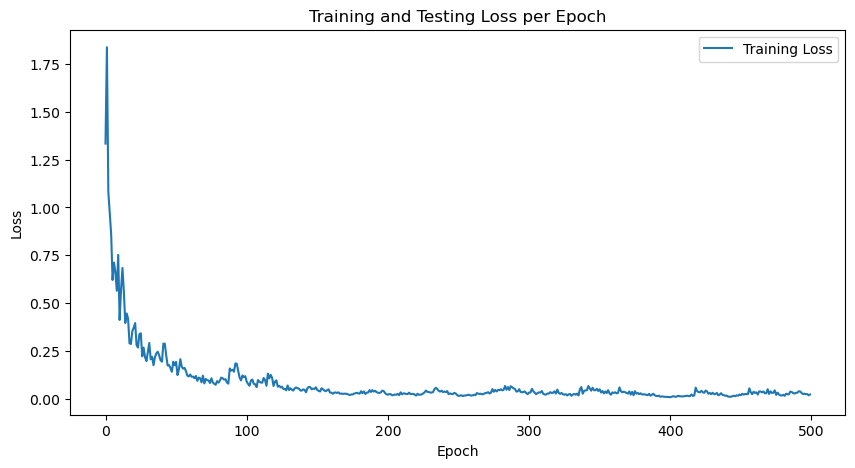

In [5]:
from matplotlib import pyplot as plt
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from sklearn.preprocessing import StandardScaler

# Neural Network Model
class RegressionNN(nn.Module):
    def __init__(self, input_size, output_size):
        super(RegressionNN, self).__init__()
        self.fc1 = nn.Linear(input_size, 256)
        self.fc2 = nn.Linear(256, 256)
        self.fc3 = nn.Linear(256, output_size)
        nn.init.kaiming_normal_(self.fc1.weight, mode='fan_in', nonlinearity='leaky_relu')
        nn.init.kaiming_normal_(self.fc2.weight, mode='fan_in', nonlinearity='leaky_relu')

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# Custom Dataset
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, features, targets):
        self.features = features
        self.targets = targets

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        return self.features[idx], self.targets[idx]

# Load Data
def load_data(file_path):
    df = pd.read_csv(file_path)
    features = df.drop(columns=[f'f{i}' for i in range(1, 13)]).values
    targets = df[[f'f{i}' for i in range(1, 13)]].values
    return features, targets

# Prepare Data
scaler = StandardScaler()
X_train, y_train = load_data('../Data/training.csv')
X_train = scaler.fit_transform(X_train)
X_test, y_test = load_data('../Data/reference.csv') #testing
X_test = scaler.transform(X_test)
y_reference = pd.read_csv('../Data/reference.csv')[[f'f{i}' for i in range(1, 13)]].values

train_dataset = CustomDataset(torch.tensor(X_train, dtype=torch.float32), torch.tensor(y_train, dtype=torch.float32))
test_dataset = CustomDataset(torch.tensor(X_test, dtype=torch.float32), torch.tensor(y_test, dtype=torch.float32))

train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# Model
input_size = X_train.shape[1]
output_size = y_train.shape[1]
model = RegressionNN(input_size, output_size)
losses = []

# Loss and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.0055)

# Train Model
num_epochs = 500
for epoch in range(num_epochs):
    for features, targets in train_loader:
        optimizer.zero_grad()
        outputs = model(features)
        loss = criterion(outputs, targets)
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
    losses.append(loss.item())
    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {loss.item()}')

# Evaluate Model
model.eval()
total_loss = 0
predictions = []
with torch.no_grad():
    for features, targets in test_loader:
        outputs = model(features)
        loss = criterion(outputs, targets)
        total_loss += loss.item()
        # Round the outputs to the nearest integer
        rounded_outputs = torch.round(outputs).numpy()
        predictions.extend(rounded_outputs)

avg_loss = total_loss / len(test_loader)
print(f'Average Testing Loss: {avg_loss}')

# Compare with Reference and Calculate Accuracy
accuracy_list = []
for i in range(12):
    correct = sum(1 for j in range(len(predictions)) if predictions[j][i] == y_reference[j][i])
    accuracy = correct / len(predictions)
    accuracy_list.append(accuracy)

# Save results
print('Monthly Accuracy:\n')
for i, acc in enumerate(accuracy_list, 1):
    print(f'Month {i}: {acc:.2f}\n')

plt.figure(figsize=(10, 5))
plt.plot(losses, label='Training Loss')
plt.title('Training and Testing Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [21]:
import pandas as pd
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, accuracy_score

train_df = pd.read_csv('../Data/training.csv')
test_df = pd.read_csv('../Data/testing.csv')
reference_df = pd.read_csv('../Data/reference.csv')

X_train = train_df.drop(columns=[f'f{i}' for i in range(1, 13)])
y_train = train_df[[f'f{i}' for i in range(1, 13)]]
X_test = test_df.drop(columns=[f'f{i}' for i in range(1, 13)])
y_test = reference_df[[f'f{i}' for i in range(1, 13)]]

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

knn = KNeighborsClassifier(n_neighbors=10)
knn.fit(X_train_scaled, y_train)

predictions = knn.predict(X_test_scaled)


print("KNN Classification Report for each month:\n")
overall_accuracy = 0
for i in range(1, 13):
    report = classification_report(y_test[f'f{i}'], predictions[:, i-1], zero_division=0)
    print(f"\nMonth {i} Report:\n")
    print(report)
    accuracy = accuracy_score(y_test[f'f{i}'], predictions[:, i-1])
    overall_accuracy += accuracy
    print(f"Accuracy for Month {i}: {accuracy}\n")

overall_accuracy /= 12
print(f"\nAverage Accuracy Across All Months: {overall_accuracy}\n")


KNN Classification Report for each month:


Month 1 Report:

              precision    recall  f1-score   support

           1       0.45      0.88      0.60        33
           2       0.40      0.15      0.22        27
           3       0.20      0.17      0.18        12
           4       0.45      0.31      0.37        16
           5       0.00      0.00      0.00         8

    accuracy                           0.42        96
   macro avg       0.30      0.30      0.27        96
weighted avg       0.37      0.42      0.35        96

Accuracy for Month 1: 0.4166666666666667


Month 2 Report:

              precision    recall  f1-score   support

           1       0.49      0.74      0.59        31
           2       0.45      0.35      0.39        26
           3       0.46      0.46      0.46        13
           4       0.67      0.12      0.20        17
           5       0.54      0.78      0.64         9

    accuracy                           0.49        96
   macro a